In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [12]:
df= pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv")

In [13]:
df.isna().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [14]:
df.fillna(0, inplace=True)

In [15]:
df.isna().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

In [16]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)

(5822, 1941, 1941)

In [18]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [28]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [29]:
train_dicts = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [30]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [32]:
y_pred = dt.predict(X_val)
y_pred

array([16.88218854, 16.88218854, 16.88218854, ..., 12.9383797 ,
       12.9383797 , 16.88218854], shape=(1941,))

In [33]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=10, random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

np.float64(0.4599777557336148)

In [45]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rm = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, rm))

    n_estimators      rmse
0             10  0.459978
1             20  0.453659
2             30  0.450743
3             40  0.448007
4             50  0.446151
5             60  0.445266
6             70  0.444610
7             80  0.444893
8             90  0.444724
9            100  0.444318
10           110  0.443135
11           120  0.443529
12           130  0.443364
13           140  0.443180
14           150  0.442910
15           160  0.442629
16           170  0.442716
17           180  0.442362
18           190  0.442579
19           200  0.442607


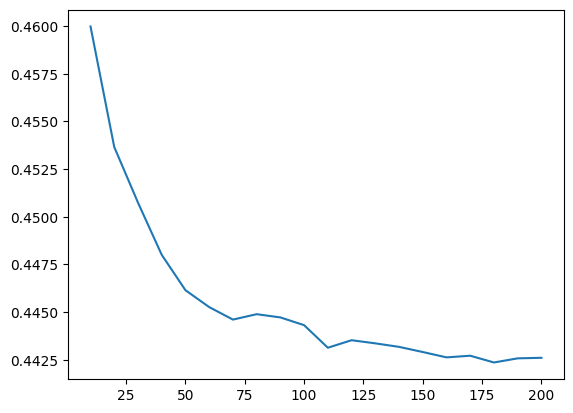

In [46]:
from matplotlib import pyplot as plt
%matplotlib inline

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
print(df_scores)
plt.plot(df_scores.n_estimators, df_scores.rmse)


In [49]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rm = np.sqrt(mean_squared_error(y_val, y_pred))
        
        scores.append((d, n, rm))


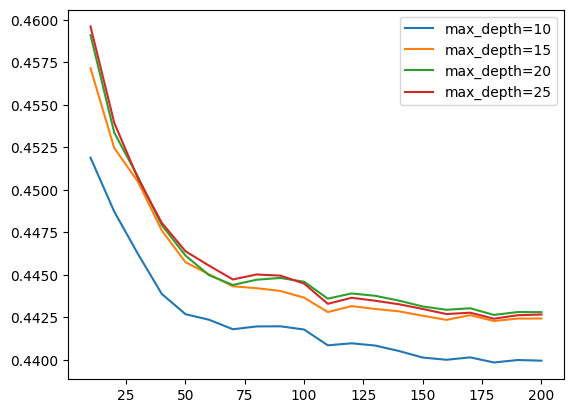

In [50]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

In [53]:
rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.3f}")
features = dv.get_feature_names_out()
importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nFeature Importances:")
print(importance_df)

Validation RMSE: 0.459

Feature Importances:
                         feature  importance
13                vehicle_weight    0.959162
6                     horsepower    0.016040
0                   acceleration    0.011471
3            engine_displacement    0.003269
7                     model_year    0.003182
8                  num_cylinders    0.002359
9                      num_doors    0.001591
12                    origin=USA    0.000555
11                 origin=Europe    0.000520
10                   origin=Asia    0.000476
1     drivetrain=All-wheel drive    0.000382
4               fuel_type=Diesel    0.000344
5             fuel_type=Gasoline    0.000337
2   drivetrain=Front-wheel drive    0.000312


In [55]:
!pip install xgboost

import xgboost as xgb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 58.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 47.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]m1/2 [xgboost]

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [56]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [57]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)
y_pred = model.predict(dval)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.3f}")

[0]	train-rmse:1.81393	val-rmse:1.85444
[1]	train-rmse:1.31919	val-rmse:1.35353
[2]	train-rmse:0.98120	val-rmse:1.01316
[3]	train-rmse:0.75443	val-rmse:0.78667
[4]	train-rmse:0.60680	val-rmse:0.64318
[5]	train-rmse:0.51381	val-rmse:0.55664
[6]	train-rmse:0.45470	val-rmse:0.50321
[7]	train-rmse:0.41881	val-rmse:0.47254
[8]	train-rmse:0.39534	val-rmse:0.45509
[9]	train-rmse:0.38038	val-rmse:0.44564
[10]	train-rmse:0.37115	val-rmse:0.43896
[11]	train-rmse:0.36361	val-rmse:0.43594
[12]	train-rmse:0.35850	val-rmse:0.43558
[13]	train-rmse:0.35365	val-rmse:0.43394
[14]	train-rmse:0.35025	val-rmse:0.43349
[15]	train-rmse:0.34666	val-rmse:0.43362
[16]	train-rmse:0.34459	val-rmse:0.43378
[17]	train-rmse:0.34128	val-rmse:0.43405
[18]	train-rmse:0.33822	val-rmse:0.43391
[19]	train-rmse:0.33709	val-rmse:0.43374
[20]	train-rmse:0.33553	val-rmse:0.43376
[21]	train-rmse:0.33243	val-rmse:0.43453
[22]	train-rmse:0.33031	val-rmse:0.43510
[23]	train-rmse:0.32815	val-rmse:0.43601
[24]	train-rmse:0.32670	va

In [58]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)
y_pred = model.predict(dval)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.3f}")

[0]	train-rmse:2.28944	val-rmse:2.34561
[1]	train-rmse:2.07396	val-rmse:2.12434
[2]	train-rmse:1.88066	val-rmse:1.92597
[3]	train-rmse:1.70730	val-rmse:1.74987
[4]	train-rmse:1.55163	val-rmse:1.59059
[5]	train-rmse:1.41247	val-rmse:1.44988
[6]	train-rmse:1.28796	val-rmse:1.32329
[7]	train-rmse:1.17660	val-rmse:1.20930
[8]	train-rmse:1.07736	val-rmse:1.10830
[9]	train-rmse:0.98883	val-rmse:1.02009
[10]	train-rmse:0.91008	val-rmse:0.94062
[11]	train-rmse:0.84030	val-rmse:0.87100
[12]	train-rmse:0.77874	val-rmse:0.80916
[13]	train-rmse:0.72417	val-rmse:0.75465
[14]	train-rmse:0.67626	val-rmse:0.70780
[15]	train-rmse:0.63402	val-rmse:0.66672
[16]	train-rmse:0.59690	val-rmse:0.63062
[17]	train-rmse:0.56447	val-rmse:0.60016
[18]	train-rmse:0.53619	val-rmse:0.57383
[19]	train-rmse:0.51138	val-rmse:0.55044
[20]	train-rmse:0.48983	val-rmse:0.53064
[21]	train-rmse:0.47135	val-rmse:0.51451
[22]	train-rmse:0.45501	val-rmse:0.49998
[23]	train-rmse:0.44120	val-rmse:0.48790
[24]	train-rmse:0.42929	va